In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Callable, Dict, List, Literal, Optional, Sequence, Tuple, Type, Union
import torch
from torch import nn
from CustomDataset import CustomTomogramDataset
from torchvision.transforms import v2
from CustomTransform import RandomCrop3D, RandomFlip

%matplotlib inline

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
class SuperRes(nn.Module):
    def __init__(self, repeats: int=3, d:int = 56, s:int = 16, scale:int = 2):
        super(SuperRes, self).__init__()
        self.repeats = repeats
        self.feature = self.conv_layer(1,d,5,1)
        self.shrinking = self.conv_layer(d,s,1,1)
        self.mapping = self.conv_layer(s,s,3,1)
        self.expanding = self.conv_layer(s,d,1,1)
        self.output = nn.ConvTranspose3d(d,1,9,scale, padding=9//2, output_padding=scale-1)    

    def forward(self, input):
        x = self.feature(input)
        x = self.shrinking(x)
        for i in range(self.repeats):
           x = self.mapping(x)
        x = self.mapping(x)
        x = self.expanding(x)
        return self.output(x)

    def conv_layer(self, layer_in, layer_out, kernel, stride):
        return nn.Sequential(nn.Conv3d(layer_in, layer_out, kernel, stride, padding=kernel//2)
                             ,nn.PReLU())

class my_model(nn.Module):
    def __init__(self):
        super(my_model, self).__init__()

        self.body = nn.Sequential(
            self.conv_layer(1, 32, kernel=5),
            self.conv_layer(32, 16, kernel=3),
        )
        #self.upscale = nn.functional.interpolate(scale_factor=2)
        self.output = self.conv_layer(16, 1)

    def forward(self, input):
        x = nn.functional.interpolate(input, scale_factor=2)
        x = self.body(x)

        return self.output(x)

    def conv_layer(
        self,
        layer_in: int,
        layer_out: int,
        kernel=1,
        stride=1,
    ) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv3d(layer_in, layer_out, kernel, stride, padding="same"),
            nn.InstanceNorm3d(layer_out),
            nn.Tanh(),
        )


def train(dataLoader, model, loss_fn, optimiser):

    size = len(dataLoader.dataset)
    model.train()

    for batch_idx, (X, y) in enumerate(dataLoader):
        X, y = X.to(device), y.to(device)
        #X, y = torch.cat(X,dim=0), torch.cat(y, dim=0)
        #X, y = X.to(device), y.to(device)

        pred = model(X)
        #print("Source Shape: ", X.shape)
        #print("Target Shape: ", y.shape)
        #print("Pred Shape: ", pred.shape)
        loss = loss_fn(pred*100, y*100)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        torch.cuda.empty_cache()
        if batch_idx % 100 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(X)
            distance = torch.median(torch.cdist(pred, y))/torch.median(y)*100
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            print(f"Distance: {distance:>3f}")


def test(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct, distance = 0, 0, 0
    with torch.no_grad():

        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            distance += torch.median(torch.cdist(pred, y))/torch.median(y)*100
            torch.cuda.empty_cache()

    test_loss /= num_batches
    correct /= size
    distance /= size

    
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, Distance: {distance:>3f} \n"
    )

In [4]:
transforms = v2.Compose([
    RandomCrop3D()
    , RandomFlip()
])
tomograms = CustomTomogramDataset(
    "./CZII_files/train/static/ExperimentRuns/*/*/denoised*",
    2,
    1,
    transforms,
    random_get=True
)

test_tomograms = CustomTomogramDataset(
    "./CZII_files/test/static/ExperimentRuns/*/*/denoised*",
    2,
    1,
    transforms,
    random_get=True
)

In [6]:
tomograms[0][1]*1000000
#original.size()
# upscaled = nn.Upsample(scale = 2)

(22, 105, 82)


tensor([[[[ -3.0941,   9.4289,  -2.5618,  ...,  -1.6515,   2.0190,   3.5836],
          [ -0.3435,   4.6527,  -3.9483,  ...,   1.2427,   1.2465,   1.7670],
          [ -1.5026,  -8.3200,  -4.5392,  ...,   5.9095,  -0.2057,   3.0133],
          ...,
          [ -1.4383,  -5.7705,   0.8587,  ...,   3.1083,  -6.3305,   1.0263],
          [-16.3943,  -1.2355,   2.4435,  ...,   2.0721,   1.5785, -11.4010],
          [ -3.4232,  -1.1066,   0.1989,  ...,  -1.0527,   5.3322,  -3.3192]],

         [[ -3.3525,  10.8723,   2.5585,  ...,  -2.3615,   4.9912,  -0.1015],
          [ -0.7812,   2.2448,   0.5366,  ...,   0.9709,   1.6257,   1.6677],
          [ -0.5754, -12.0524,  -1.6150,  ...,   2.6572,  -0.4903,   4.7989],
          ...,
          [ -0.3027,  -4.2957,  -3.0332,  ...,   8.4968,  -7.5253,   4.9201],
          [-17.5498,  -0.6700,   2.0333,  ...,   4.1169,  -1.3247,  -2.6488],
          [ -2.6346,  -2.4762,  -1.3476,  ...,   1.4213,   2.4215,  -0.2311]],

         [[ -3.6077,  10.5576,

In [7]:
data_loader = torch.utils.data.DataLoader(tomograms, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_tomograms, batch_size=1)
# min, max = tomograms.get_tensor_range()
model = SuperRes(scale=2, d=36, s=12).to(device)
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)

In [8]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(data_loader, model, loss_fn, optimiser)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 434.658264  [    1/    7]
Distance: 142188816.000000
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.008425, Distance: 127400856.000000 

Epoch 2
-------------------------------
loss: 82.924042  [    1/    7]
Distance: 100622208.000000
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.003866, Distance: 86440792.000000 

Epoch 3
-------------------------------
loss: 39.372330  [    1/    7]
Distance: 71597784.000000
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.001548, Distance: 46314444.000000 

Epoch 4
-------------------------------
loss: 14.966368  [    1/    7]
Distance: 66193620.000000
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000786, Distance: 36147272.000000 

Epoch 5
-------------------------------
loss: 8.052201  [    1/    7]
Distance: 35890500.000000
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.000503, Distance: 24153656.000000 

Epoch 6
-------------------------------
loss: 4.901825  [    1/    7]
Distance: 28191318.000000
Test Error: 
 Accuracy: 45

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [15]:
# torch.cuda.empty_cache()
source, target = test_loader.dataset[2]

upscaled = nn.functional.interpolate(source[np.newaxis, ...], size=(92, 315, 315))
upsampled = nn.Upsample(
    scale_factor=2, recompute_scale_factor=True, mode="nearest-exact"
)(source[np.newaxis, ...])
upsampled.size()
# model.eval()
# gpu_source = source[np.newaxis, ...]
# gpu_source = gpu_source.to(device)
# model_output = model(gpu_source)

source size:  46 97 158 from:  (46, 158, 158)
target size:  92 194 316 from:  (92, 315, 315)
(41, 91, 130)


torch.Size([1, 1, 82, 182, 260])

(np.float64(-0.5), np.float64(259.5), np.float64(181.5), np.float64(-0.5))

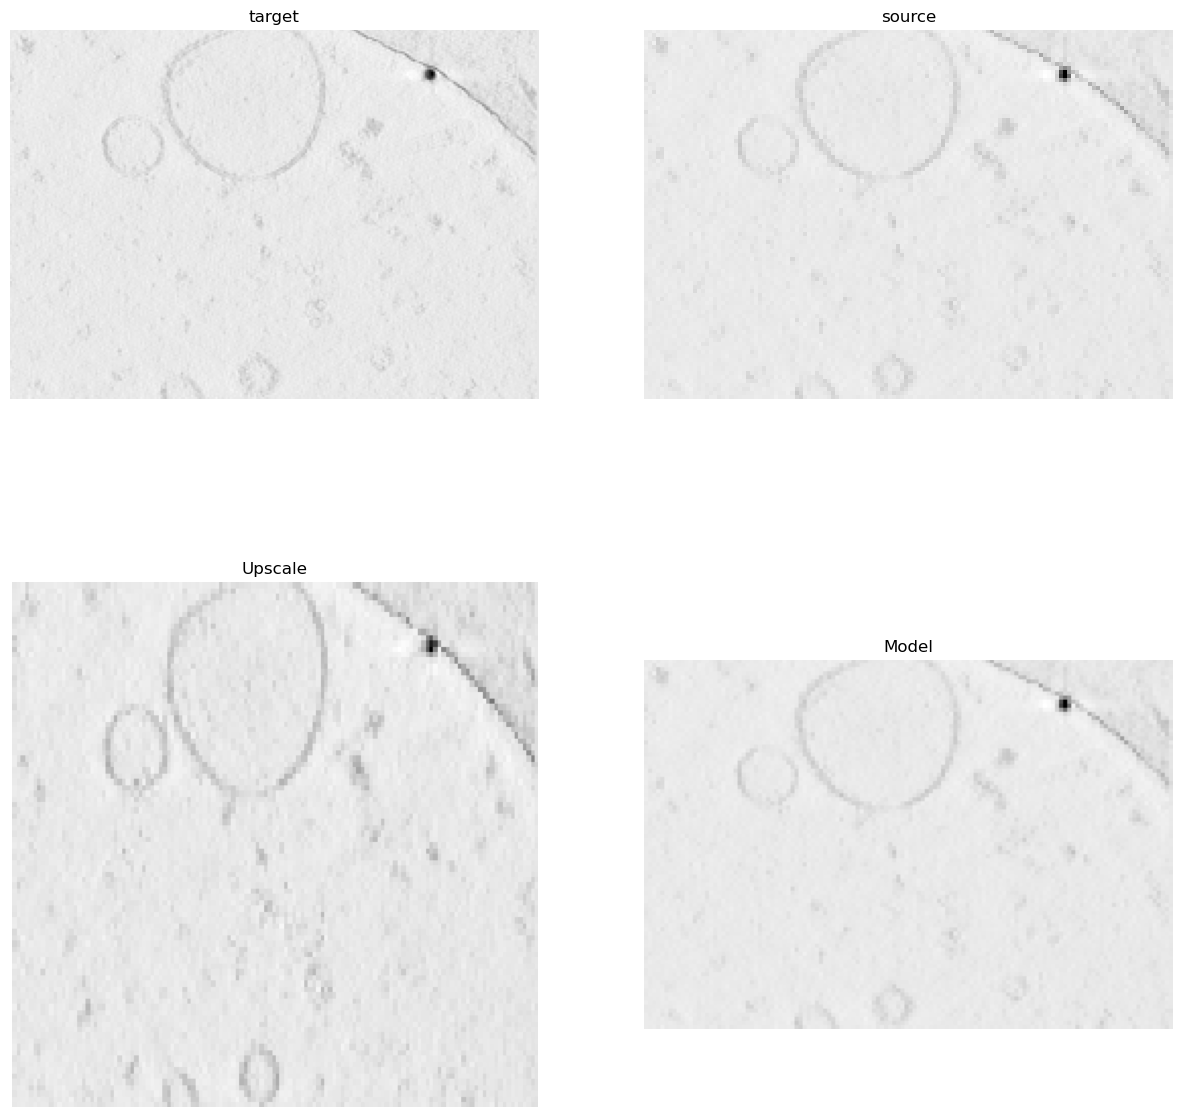

In [16]:
source_np = source.cpu().numpy()[0]
target_np = target[0].numpy()
upscaled_np = upscaled.numpy()[0][0]
# model_output_np = model_output.cpu().detach().numpy()[0][0]
upsampled_np = upsampled.numpy()[0][0]
plt.figure(figsize=(15, 15))

# Original Image
plt.subplot(2, 2, 1)
plt.title("target")
plt.imshow(target_np[20, :, :], cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("source")
plt.imshow(source_np[10, :, :], cmap="gray")
plt.axis("off")
# [60, 278:308, 353:385]
# Original Image
plt.subplot(2, 2, 3)
plt.title("Upscale")
plt.imshow(upscaled_np[20, :, :], cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Model")
plt.imshow(upsampled_np[20, :, :], cmap="gray")
plt.axis("off")

In [47]:
print(target)

tensor([[[[ 5.6532e-07,  1.8766e-06, -1.5837e-07,  ..., -1.2208e-06,
           -1.3775e-06, -3.4589e-06],
          [ 5.2822e-06,  2.7378e-06, -2.1889e-06,  ..., -3.0236e-06,
            3.9271e-07, -3.9640e-07],
          [ 2.3636e-06,  2.1738e-06, -2.1472e-06,  ...,  2.1746e-07,
           -3.7890e-06, -1.2341e-06],
          ...,
          [ 7.3559e-07,  9.6241e-08, -5.1283e-09,  ..., -2.6697e-07,
           -2.3157e-06,  1.0619e-06],
          [ 5.9994e-07, -4.1256e-07,  5.2623e-07,  ..., -1.1891e-06,
           -1.8381e-06,  4.0025e-06],
          [ 5.3226e-07,  3.3414e-07,  7.2097e-07,  ..., -6.0247e-06,
           -2.8592e-06,  7.0183e-07]],

         [[ 7.0605e-07,  6.9861e-06, -1.2213e-06,  ..., -1.2628e-06,
           -3.1545e-06, -5.4199e-06],
          [ 1.2902e-06,  1.0800e-05,  1.6183e-07,  ...,  3.3934e-08,
            2.1399e-06, -1.6135e-06],
          [ 3.5695e-06,  5.1422e-06, -2.6419e-06,  ...,  1.1488e-06,
           -5.9091e-06, -1.3316e-06],
          ...,
     

In [39]:
print(model_output_np[20, :, :])

[[ 0.22465077  0.22465077 -0.99996233 ... -0.66834193 -0.66834193
   0.9949052 ]
 [ 0.22465077  0.22465077 -0.99996233 ... -0.66834193 -0.66834193
   0.9949052 ]
 [-0.09595629 -0.09595629 -0.9999998  ... -0.8735724  -0.8735724
   0.99997383]
 ...
 [ 0.4932096   0.4932096  -0.9999996  ... -0.6458103  -0.6458103
   0.9999738 ]
 [ 0.4932096   0.4932096  -0.9999996  ... -0.6458103  -0.6458103
   0.9999738 ]
 [ 0.80254465  0.80254465 -0.9998989  ... -0.7582282  -0.7582282
   0.99541944]]


In [32]:
model_output.cpu().detach()

tensor([[[[[ 0.3988,  0.3988, -0.9956,  ...,  0.1150,  0.1150,  0.9300],
           [ 0.3988,  0.3988, -0.9956,  ...,  0.1150,  0.1150,  0.9300],
           [ 0.4639,  0.4639, -0.9998,  ...,  0.1925,  0.1925,  0.9975],
           ...,
           [ 0.6124,  0.6124, -0.9996,  ...,  0.5181,  0.5181,  0.9980],
           [ 0.6124,  0.6124, -0.9996,  ...,  0.5181,  0.5181,  0.9980],
           [ 0.8387,  0.8387, -0.9683,  ...,  0.6391,  0.6391,  0.9713]],

          [[ 0.3988,  0.3988, -0.9956,  ...,  0.1150,  0.1150,  0.9300],
           [ 0.3988,  0.3988, -0.9956,  ...,  0.1150,  0.1150,  0.9300],
           [ 0.4639,  0.4639, -0.9998,  ...,  0.1925,  0.1925,  0.9975],
           ...,
           [ 0.6124,  0.6124, -0.9996,  ...,  0.5181,  0.5181,  0.9980],
           [ 0.6124,  0.6124, -0.9996,  ...,  0.5181,  0.5181,  0.9980],
           [ 0.8387,  0.8387, -0.9683,  ...,  0.6391,  0.6391,  0.9713]],

          [[ 0.7421,  0.7421, -0.9999,  ..., -0.3805, -0.3805,  0.9962],
           [ 0.